## Import Packages

In [93]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

`grayscale()`applies the Grayscale transform and returns an image with only one color channel.  
`canny()` applies the Canny transform.  
`gaussian_blur()` applies a Gaussian Noise kernel.  
`region_of_interest()` applies an image mask.  
`draw_lines()` processes the raw lane line segments and visualizes the final lane lines.  
`hough_lines()` returns an image with hough lines drawn.  
`weighted_img()` combines two images into a single image.  


In [94]:
import math

def grayscale(img):
    """NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')
    Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = draw_lines(img, lines, [255, 0, 0], 2);
    
    return line_img, lines

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Draw an array of line segments on a blank image
    """
    line_img=np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8);
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img

def slope_thresholding(img,lines):
    """
    This function isolates somewhat vertical line segments.
    Then, it divides raw line segments into left and right lane.
    """
    lane_raw=[];
    #Ignore segments which are somewhat horizantal
    for pts in lines:
        for x1,y1,x2,y2 in pts:
            m=(y2-y1)/(x2-x1)
            if m>.25 or m<-.25:
                lane_raw.append(pts)
    
    #Separate left and right lanes
    left_lane_raw=[];
    right_lane_raw=[];
    for pts in lane_raw:
        for x1,y1,x2,y2 in pts:
            slope=((y2-y1)/(x2-x1));
            if slope<0:
                left_lane_raw.append(pts)
            else:
                right_lane_raw.append(pts)
                
    left_raw_img = draw_lines(img, left_lane_raw, [0, 255, 0], 2)
    right_raw_img = draw_lines(img, right_lane_raw, [0, 0, 255], 2)
    
    
    raw_lane_img = weighted_img(left_raw_img,right_raw_img,1,1,0)
    return raw_lane_img, left_lane_raw, right_lane_raw
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def draw_lanes(img, left_lane_raw, right_lane_raw):
    """
    This function plots left and right lane lines on dashcam image
    
    Input: 
    img= Color image from dashcam
    lines= Set of line segments which denote parts of lane lines
    
    The raw lines are aggregated into single line segments denoting lane lines
    Finally, both the lines are plotted on road to visualize
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #Find Top and Bottom x values of the lane
    #y_top=lines[0][0][1]
    #y_bottom=lines[0][0][1]
    #for pts in lines:
    #    for x1,y1,x2,y2 in pts:
    #        if y_top>y1:
    #            y_top=y1
    #        if y_bottom<y1:
    #            y_bottom=y1
    #        if y_top>y2:
    #            y_top=y2
    #        if y_bottom<y2:
    #            y_bottom=y2
    y_bottom=img.shape[0]
    y_top=.6*img.shape[0]

    #Calculate Left lane
    left_x,left_y,left_m,left_c=avg_line(left_lane_raw)
    left_lane=np.array([(y_top-left_c)/left_m,y_top,(y_bottom-left_c)/left_m,y_bottom]);
    left_lane=left_lane.astype(int)

    #Calculate Right lane
    right_x,right_y,right_m,right_c=avg_line(right_lane_raw)
    right_lane=np.array([(y_top-right_c)/right_m,y_top,(y_bottom-right_c)/right_m,y_bottom]);
    right_lane=right_lane.astype(int)
    
    lane=[[left_lane] , [right_lane]]
    if left_lane[0]>10000 or left_lane[0]<0 or right_lane[0]>10000 or right_lane[0]<0:
        return
    
    lane_img=draw_lines(img, lane);    
    return lane_img

def avg_line(lines):
    avg_pt=np.array([0,0])
    slope_arr=np.array([]);
    for pts in lines:
        for x1,y1,x2,y2 in pts:
            m=(y2-y1)/(x2-x1)
            slope_arr=np.append(slope_arr,m)
            avg_pt=avg_pt+[(x1+x2)/2.0,(y1+y2)/2.0]
    slope=np.median(slope_arr)
    avg_pt=avg_pt/len(slope_arr)
    x=avg_pt[0]
    y=avg_pt[1]
    intercept= y-slope*x
    
    #print (x,y,slope,intercept)
    return x,y,slope,intercept
    

## Image Processing Pipeline



This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
1.Input


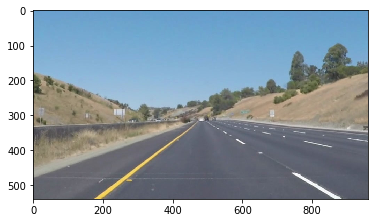

2.Grayscaling


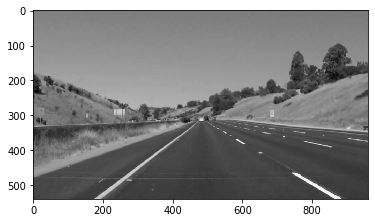

3.Blurring


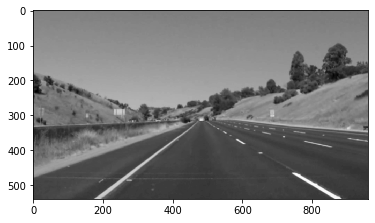

4.Edge Detection


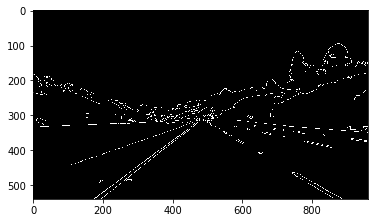

5.Region Masking


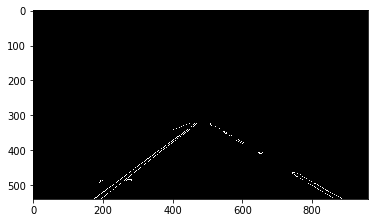

6.Hough Transform


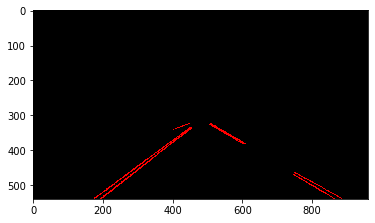

7.Slope Thresholding


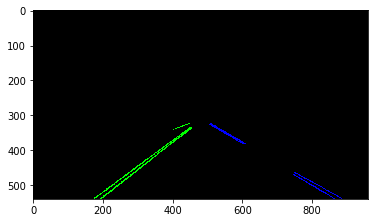

8.Line averaging


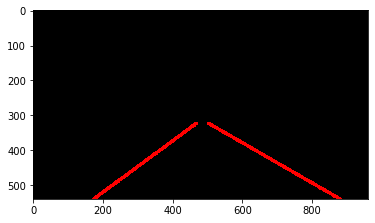

Final Visualization


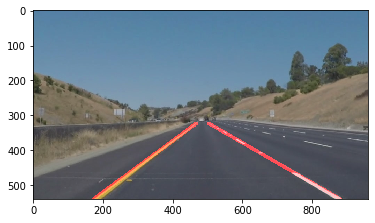

True

In [95]:
#STEP 1- INPUT
Img1 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
print('This image is:', type(Img1), 'with dimensions:', image.shape)
print("1.Input")
plt.imshow(Img1)
plt.show()


#STEP 2- Grayscaling
Img2=grayscale(Img1)
print("2.Grayscaling")
plt.imshow(Img2, cmap='gray')
plt.show()


#STEP 3- Blurring
Img3=gaussian_blur(Img2, 5)
print("3.Blurring")
plt.imshow(Img3, cmap='gray')
plt.show()


#STEP 4- Edge detection
Img4=canny(Img3, 50, 150)
print("4.Edge Detection")
plt.imshow(Img4, cmap='gray')
plt.show()


#STEP 5- Region Masking
Low_Lf=[.05*image.shape[1],image.shape[0]]
Up_Lf=[.45*image.shape[1],.6*image.shape[0]]
Up_Rt=[.55*image.shape[1],.6*image.shape[0]]
Low_Rt=[.95*image.shape[1],image.shape[0]]
poly=np.array([[Low_Lf,Up_Lf,Up_Rt,Low_Rt]], dtype=np.int32)
Img5=region_of_interest(Img4, poly)
print("5.Region Masking")
plt.imshow(Img5, cmap='gray')
plt.show()


#STEP 6- Hough Transform
#Detecting line segments from edge pixels and creating blank image with lane lines
rho = 2
theta = np.pi/90
threshold = 40
min_line_len = 30
max_line_gap = 20
(Img6,lines)=hough_lines(Img5, rho, theta, threshold, min_line_len, max_line_gap)
print("6.Hough Transform")
plt.imshow(Img6)
plt.show()


#STEP 7- Slope Thresholding
(Img7,left_raw,right_raw)=slope_thresholding(Img6,lines)
print("7.Slope Thresholding")
plt.imshow(Img7)
plt.show()


#STEP 8- Averaging Raw lines
Img8=draw_lanes(Img7,left_raw,right_raw)
print("8.Line averaging")
plt.imshow(Img8)
plt.show()

#STEP 9- Final Visualization
#Superimposing lanes on original image
Img9=weighted_img(Img8, image)
print("Final Visualization")
plt.imshow(Img9)
plt.show()
cv2.imwrite("test_images_output/whiteCarLaneSwitch.jpg",Finalimage)

In [96]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Combine each prossing step as a Detailed image


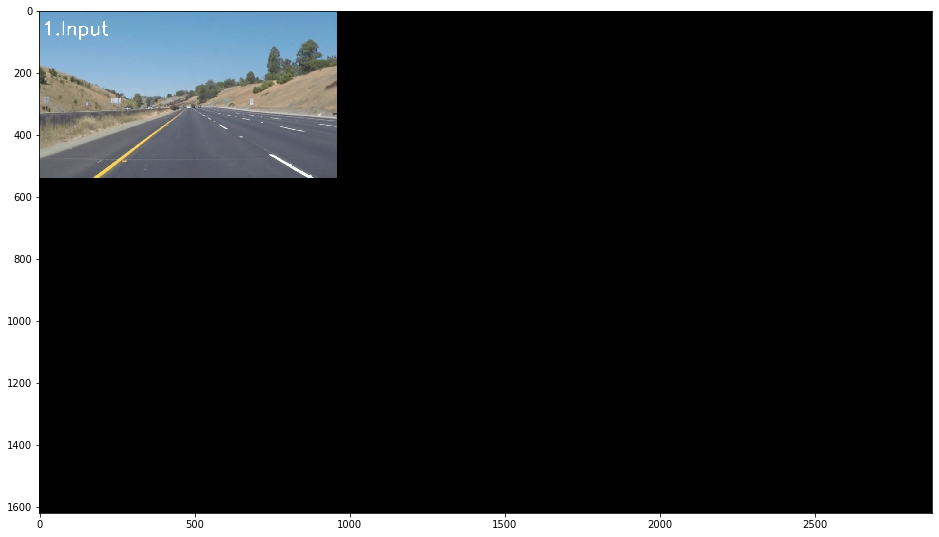

In [97]:
ht=image.shape[0]
wd=image.shape[1]
DetailImg=np.zeros((3*ht, 3*wd, 3), dtype=np.uint8);
DetailImg[:ht,:wd]=image;


#Combile all images and show results
font = cv2.FONT_HERSHEY_SIMPLEX
scale = 2
color = (255,255,255)
thickness = 4
linetype = cv2.LINE_AA
cv2.putText(DetailImg, "1.Input", (10,80), font, scale,color,thickness,linetype)

fig1 = plt.figure(figsize = (16,16))
ax1 = fig1.add_subplot(111)
ax1.imshow(DetailImg)
plt.show()
